# Iowa Liquor Sales Analysis
This data is available from https://data.iowa.gov/api/views/m3tr-qhgy/rows.csv?accessType=DOWNLOAD.

## Setup & Imports

In [0]:
# Common imports
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import os

# Plotting imports and settings
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (13,8)

# Metrics and useful imports
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [0]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = "."

imgpath = os.path.join(PROJECT_ROOT_DIR, "images")
if not os.path.exists(imgpath):
    os.makedirs(imgpath)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [0]:
# Make output stable
np.random.seed(0)

In [0]:
isLocal = True

filename = "Iowa_Liquor_Sales.csv"
google_drv_path = "/content/drive/My Drive/TestingData/"
local_path = "../../DataSets/Iowa/"
if not isLocal: 
  !pip install -U -q PyDrive
  from google.colab import drive
  drive.mount("/content/drive", force_remount=True)
  full_filepath = google_drv_path + filename
else:
  full_filepath = local_path + filename 

## Understand

### Iowa Liquor Sales Data (January 1, 2012 - March 11, 2020)
This Iowa liquor sale databases was obtain from the Iowa Department of Commerce, Alcoholic Beverages Division , and was updated monthly. 

This dataset contains the spirits purchase information of Iowa Class “E” liquor licensees by product and date of purchase from January 1, 2012 to current. The dataset can be used to analyze total spirits sales in Iowa of individual products at the store level.

Class E liquor license, for grocery stores, liquor stores, convenience stores, etc., allows commercial establishments to sell liquor for off-premises consumption in original unopened containers.


## Load

In [0]:
%%time
IowaSales = pd.read_csv(full_filepath, low_memory=False)
IowaSales.shape

Wall time: 1min 17s


(18098417, 24)

This dataset comprised over 18 million rows and 24 column of data.

## Explore

In [0]:
size = IowaSales.shape[0]
if(pd.options.display.max_info_rows <= size):
  pd.options.display.max_info_rows = size + 1


In [0]:
IowaSales.isna().sum()

Invoice/Item Number            0
Date                           0
Store Number                   0
Store Name                     0
Address                    79803
City                       79802
Zip Code                   79847
Store Location           1746005
County Number             156607
County                    156605
Category                   16617
Category Name              24683
Vendor Number                  5
Vendor Name                    3
Item Number                    0
Item Description               0
Pack                           0
Bottle Volume (ml)             0
State Bottle Cost             10
State Bottle Retail           10
Bottles Sold                   0
Sale (Dollars)                10
Volume Sold (Liters)           0
Volume Sold (Gallons)          0
dtype: int64

### Attribute Information
0. **`Invoice/Item Number`**    
1. **`Date`**                  
2. **`Store Number`**           
3. **`Store Name`**:            
4. **`Address`**: miss 79803 values,               
5. **`City`**: miss 79802 values,                    
6. **`Zip Code`**: miss 79847 values,                
7. **`Store Location`**: miss 1746005 values, split to longtidute and latitude         
8. **`County Number`**: miss 156607 values
9. **`County`**: miss 156605 values, 
10. **`Category`**: miss 16617 values
11. **`Category Name`**: miss 24683 values
12. **`Vendor Number`**: miss 5 values
13. **`Vendor Name`**: miss 3 values, 
14. **`Item Number`**           
15. **`Item Description`**:       
16. **`Pack`**                
17. **`Bottle Volume (ml)`**     
18. **`State Bottle Cost`**: miss 10 values
19. **`State Bottle Retail`**: miss 10 values    
20. **`Bottles Sold`**            
21. **`Sale (Dollars)`**: miss 10 values        
22. **`Volume Sold (Liters)`**   
23. **`Volume Sold (Gallons)`**  

## Scrub

* Replace any missing values using pproaches like imputation and dropping.

In [0]:
IowaSales_Copy = IowaSales.copy()
IowaSales_Copy_NoSaleNa = IowaSales_Copy.dropna(subset=['Sale (Dollars)'])
IowaSales_Copy_NoSaleNa.isna().sum()

# Try to locate some mapping for filling in some N/A data
store_locs_withna = IowaSales_Copy[['Store Number', 'Store Location', 'Zip Code', 'City', 'County Number']]
store_locs = store_locs_withna.dropna()
store_locs_unique_idx =  store_locs['Store Number'].duplicated()
store_locs_unique_idx = (store_locs_unique_idx == False)
store_locs_unique = store_locs[store_locs_unique_idx]
store_locs_unique.head()

,Store Number,Store Location,Zip Code,City,County Number
0,2642,POINT (-92.899277 41.396961000000005),50219,Pella,63.0
1,5050,POINT (-93.499634 41.49794500000001),50047,Carlisle,91.0
2,4598,POINT (-93.577655 41.627702000000006),50317,Des Moines,77.0
3,3645,POINT (-93.716991 41.594787),50311,Windsor Heights,77.0
4,2854,POINT (-93.814927 41.614948),50323,Urbandale,77.0


In [0]:
store_locs_unique_ts = store_locs_unique.set_index('Store Number')
store_locs_unique_ts

,Store Location,Zip Code,City,County Number
Store Number,,,,
2642,POINT (-92.899277 41.396961000000005),50219,Pella,63.0
5050,POINT (-93.499634 41.49794500000001),50047,Carlisle,91.0
4598,POINT (-93.577655 41.627702000000006),50317,Des Moines,77.0
3645,POINT (-93.716991 41.594787),50311,Windsor Heights,77.0
2854,POINT (-93.814927 41.614948),50323,Urbandale,77.0
...,...,...,...,...
9938,POINT (-94.936366 41.917072),51463,Templeton,14.0
9934,POINT (-90.455001 41.571059),52722,Bettendorf,82.0
9923,POINT (-94.874691 42.056362),51401,Carroll,14.0


In [0]:
# Try to map using existing mapping in data
IowaSales_Copy.loc[IowaSales_Copy['Store Location'].isna(),'Store Location'] = IowaSales_Copy['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'Store Location'] if x in store_locs_unique_ts.index else np.NaN)
IowaSales_Copy.loc[IowaSales_Copy['Zip Code'].isna(),'Zip Code'] = IowaSales_Copy['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'Zip Code'] if x in store_locs_unique_ts.index else np.NaN)
IowaSales_Copy.loc[IowaSales_Copy['City'].isna(),'City'] = IowaSales_Copy['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'City'] if x in store_locs_unique_ts.index else np.NaN)
IowaSales_Copy.loc[IowaSales_Copy['County Number'].isna(),'County Number'] = IowaSales_Copy['Store Number'].map(lambda x: store_locs_unique_ts.at[x, 'County Number'] if x in store_locs_unique_ts.index else np.NaN)
IowaSales_Copy = IowaSales_Copy.dropna(subset=['Sale (Dollars)'])

In [0]:
# CLean up to re-categorize the Categories
IowaSales_Copy['Category Name'] = IowaSales_Copy['Category Name'].apply(lambda x: x.upper() if isinstance(x, str) else None)
IowaSales_Copy['Category Name']= IowaSales_Copy['Category Name'].apply(
    lambda x: None if x is None else 
    'WHISKY' if 'WHISKIES' in x else
    'WHISKY' if 'WHISKY' in x else
    'VODKA' if 'VODKA' in x else
    'RUM' if 'RUM' in x else
    'BEER' if 'BEER' in x else    
    'TEQUILA' if 'TEQUILA' in x else    
    'COCKTAIL' if 'COCKTAIL' in x else    
    'BRANDIES' if 'BRANDIES' in x else    
    'SCHNAPPS' if 'SCHNAPPS' in x else    
    'SCOTCH' if 'SCOTCH' in x else    
    'CORDIALS & LIQUEURS' if 'CORDIAL' in x else    
    'CORDIALS & LIQUEURS' if 'LIQUEUR' in x else    
    'CORDIALS & LIQUEURS' if 'TRIPLE SEC' in x else 
    'CORDIALS & LIQUEURS' if 'AMERICAN ALCOHOL' in x else
    'AMARETTO' if 'AMARETTO' in x else
    'SPIRIT SPECIALTY' if 'DISTILLED SPIRIT' in x else
    'SPIRIT SPECIALTY' if 'SPIRIT' in x else
    'SPIRIT SPECIALTY' if 'SPECIALTY' in x else
    'SPIRIT SPECIALTY' if 'CREME' in x else
    'SPIRIT SPECIALTY' if 'BOTTLED IN BOND BOURBON' in x else  
    'SPIRIT SPECIALTY' if 'HOLIDAY VAP' in x else      
    'GINS' if 'GIN' in x else    
    'OTHERS' if 'DELISTED ITEMS' in x else
    x)

In [0]:

IowaSales_Copy.isna().sum()

Invoice/Item Number            0
Date                           0
Store Number                   0
Store Name                     0
Address                    79803
City                        6284
Zip Code                    6284
Store Location           1565382
County Number              13223
County                    156605
Category                   16617
Category Name              24683
Vendor Number                  5
Vendor Name                    3
Item Number                    0
Item Description               0
Pack                           0
Bottle Volume (ml)             0
State Bottle Cost              0
State Bottle Retail            0
Bottles Sold                   0
Sale (Dollars)                 0
Volume Sold (Liters)           0
Volume Sold (Gallons)          0
dtype: int64

In [0]:
IowaSales_copybak = IowaSales_Copy.copy()

# Extract the Longtitue/Latitude for brief visualization
IowaSales_Copy["Longtidute"] = IowaSales_Copy['Store Location'].map(lambda x: float(x.replace("(", "").replace(")","").split(" ")[1]) if isinstance(x, str) else np.NaN)
IowaSales_Copy["Latitude"] = IowaSales_Copy['Store Location'].map(lambda x: float(x.replace("(", "").replace(")","").split(" ")[2]) if isinstance(x, str) else np.NaN)

# Drop redundant columnes 
IowaSales_Copy = IowaSales_Copy.drop(['Store Name','Address','Vendor Name','Item Description', 'Invoice/Item Number', "Store Location", "County"], axis=1)

In [0]:
IowaSales_Copy.head(5)

,Date,Store Number,City,Zip Code,County Number,Category,Category Name,Vendor Number,Item Number,Pack,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),Longtidute,Latitude
0,06/21/2017,2642,Pella,50219,63.0,1081500.0,CORDIALS & LIQUEURS,65.0,86112,12,1000,2.33,3.50,12,42.00,12.0,3.17,-92.899277,41.396961
1,06/21/2017,5050,Carlisle,50047,91.0,1081400.0,SCHNAPPS,55.0,84172,10,600,6.00,9.00,1,9.00,0.6,0.16,-93.499634,41.497945
2,06/22/2017,4598,Des Moines,50317,77.0,1031200.0,VODKA,205.0,40593,24,375,3.50,5.25,4,21.00,1.5,0.40,-93.577655,41.627702
3,06/22/2017,3645,Windsor Heights,50311,77.0,1062200.0,RUM,434.0,45278,6,1750,7.84,11.76,6,70.56,10.5,2.77,-93.716991,41.594787
4,06/22/2017,2854,Urbandale,50323,77.0,1071100.0,COCKTAIL,65.0,63355,12,750,6.29,9.44,6,56.64,4.5,1.19,-93.814927,41.614948


In [0]:
# Further dropping some rare NA items after being filled with other existig mapping
IowaSales_Copy = IowaSales_Copy.dropna(subset=['Sale (Dollars)', 'City', 'Zip Code', 'Longtidute'])
IowaSales_Copy_Filled = IowaSales_Copy.fillna(method='ffill')
IowaSales_Copy_Filled.isna().sum()

Date                     0
Store Number             0
City                     0
Zip Code                 0
County Number            0
Category                 0
Category Name            0
Vendor Number            0
Item Number              0
Pack                     0
Bottle Volume (ml)       0
State Bottle Cost        0
State Bottle Retail      0
Bottles Sold             0
Sale (Dollars)           0
Volume Sold (Liters)     0
Volume Sold (Gallons)    0
Longtidute               0
Latitude                 0
dtype: int64

In [0]:
# Inspect data format before converting
IowaSales_Copy_Filled["Item Number"][IowaSales_Copy_Filled["Item Number"].map(lambda x: x.isdigit()) == False]

16560993    x904631
17595261    x904631
17611457    x904631
Name: Item Number, dtype: object

In [0]:
import datetime

# Converting 
IowaSales_Copy_Filled['Date'] = IowaSales_Copy_Filled['Date'].map(lambda x: datetime.datetime.strptime(x, '%m/%d/%Y'))
IowaSales_Copy_Filled['Month'] = IowaSales_Copy_Filled['Date'].map(lambda x: x.month)
IowaSales_Copy_Filled["City"] = IowaSales_Copy_Filled["City"].apply(lambda x: x.upper())
IowaSales_Copy_Filled["Zip Code"] = IowaSales_Copy_Filled["Zip Code"].map(lambda x: '51529' if x == '712-2' else x)
IowaSales_Copy_Filled["Item Number"] = IowaSales_Copy_Filled["Item Number"].map(lambda x: '904631' if x == 'x904631' else x)

IowaSales_Copy_Filled["Zip Code"] = IowaSales_Copy_Filled["Zip Code"].astype(int)
IowaSales_Copy_Filled["Item Number"] = IowaSales_Copy_Filled["Item Number"].astype(np.int64)

IowaSales_Copy_Filled["Pack Volume (ml)"] = IowaSales_Copy_Filled["Pack"] * IowaSales_Copy_Filled["Bottle Volume (ml)"]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16533025 entries, 0 to 18098416
Data columns (total 19 columns):
 #   Column                 Non-Null Count     Dtype  
---  ------                 --------------     -----  
 0   Store Number           16533025 non-null  int64  
 1   City                   16533025 non-null  object 
 2   Zip Code               16533025 non-null  int32  
 3   County Number          16533025 non-null  float64
 4   Category               16533025 non-null  float64
 5   Vendor Number          16533025 non-null  float64
 6   Item Number            16533025 non-null  int64  
 7   Pack                   16533025 non-null  int64  
 8   Bottle Volume (ml)     16533025 non-null  int64  
 9   State Bottle Cost      16533025 non-null  float64
 10  State Bottle Retail    16533025 non-null  float64
 11  Bottles Sold           16533025 non-null  int64  
 12  Sale (Dollars)         16533025 non-null  float64
 13  Volume Sold (Liters)   16533025 non-null  float64
 14  

<Figure size 1440x1080 with 0 Axes>

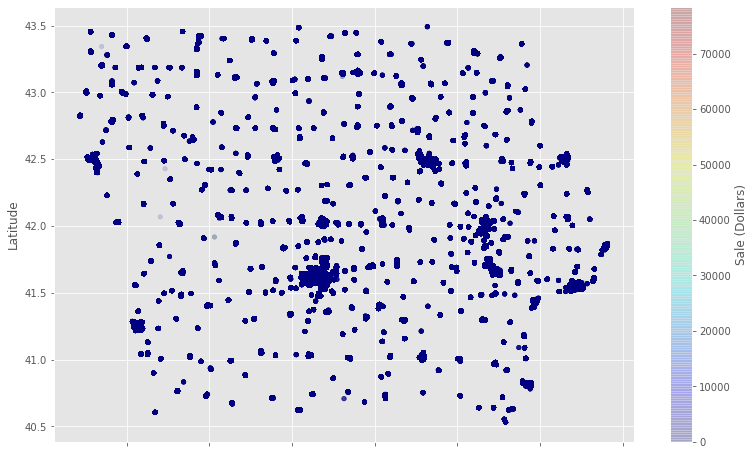

In [0]:
# Sampling for visualization
IowaSales_Main = IowaSales_Copy_Filled.drop(["Date", "Category Name"], axis=1)
IowaSales_Main.info(), IowaSales_Main.shape

m = 3000000
idx = np.random.permutation(IowaSales_Main.shape[0])[:m]
IowaSales_plot_sample = IowaSales_Main.loc[IowaSales_Main.index[idx], :]

# Fit the scale - to remove some outfiter
IowaSales_plot_sample = IowaSales_plot_sample[(((IowaSales_plot_sample["Latitude"] > 44.5) 
                                                |(IowaSales_plot_sample["Latitude"] < 40.5) 
                                                |(IowaSales_plot_sample["Longtidute"] > -75)) == False)]
plt.figure(figsize=(20,15))
IowaSales_plot_sample.plot(kind="scatter", x="Longtidute", y="Latitude", c="Sale (Dollars)", alpha=0.15, cmap=mpl.cm.get_cmap("jet"));


In [0]:
import array

def plot_digits(X, y, scalesize=10, figsize=(13, 10)):    
    plt.figure(figsize=figsize)
    interval = 100 / scalesize
    cmap = mpl.cm.get_cmap("jet")
    
    buckets = array.array('f')
    y_max = max(y)
    buckets.append(y_max)    
    for i in range(1, scalesize):
        buckets.append(np.percentile(y, interval * (scalesize - i)))    
    buckets.append(min(y))
    
    startval = 0
    bl = len(buckets)
    cur = 0
    first = True
    
    idx = (y == y_max)[:, 0]
    plt.scatter(X[idx, 0], X[idx, 1], c=[cmap(0)], s=y[idx], alpha=0.15)
    b_cur = None
    for b in buckets:
        cur = cur + 1
        b_pre = b_cur
        b_cur = b        
        if first: 
            first = False
            continue        
        idx = (y < b_pre)[:, 0] * (y >= b_cur)[:, 0]
        plt.scatter(X[idx, 0], X[idx, 1], c=[cmap(cur / bl)], s=y[idx], alpha=0.15)
        
       
    plt.axis("off")
    return plt

In [0]:
from sklearn.model_selection import train_test_split
IowaSales_Main_Bak = IowaSales_Main.copy()
y_Sale = IowaSales_Main[['Sale (Dollars)']].values
X_Sale = IowaSales_Main.drop(['Sale (Dollars)', 'City'], axis=1).values
X_Sale_train, X_Sale_test, y_Sale_train, y_Sale_test = train_test_split(X_Sale, y_Sale)

In [0]:
m = 60000
idx_sale = np.random.permutation(X_Sale_train.shape[0])[:m]
X_Sale_sampled = X_Sale_train[idx_sale]
y_Sale_sampled = y_Sale_train[idx_sale]


# Below conduct some Dimensionality Reduction work #

Wall time: 4min 42s


<module 'matplotlib.pyplot' from 'C:\\Programs\\Anaconda3\\envs\\tensorflow-env\\lib\\site-packages\\matplotlib\\pyplot.py'>

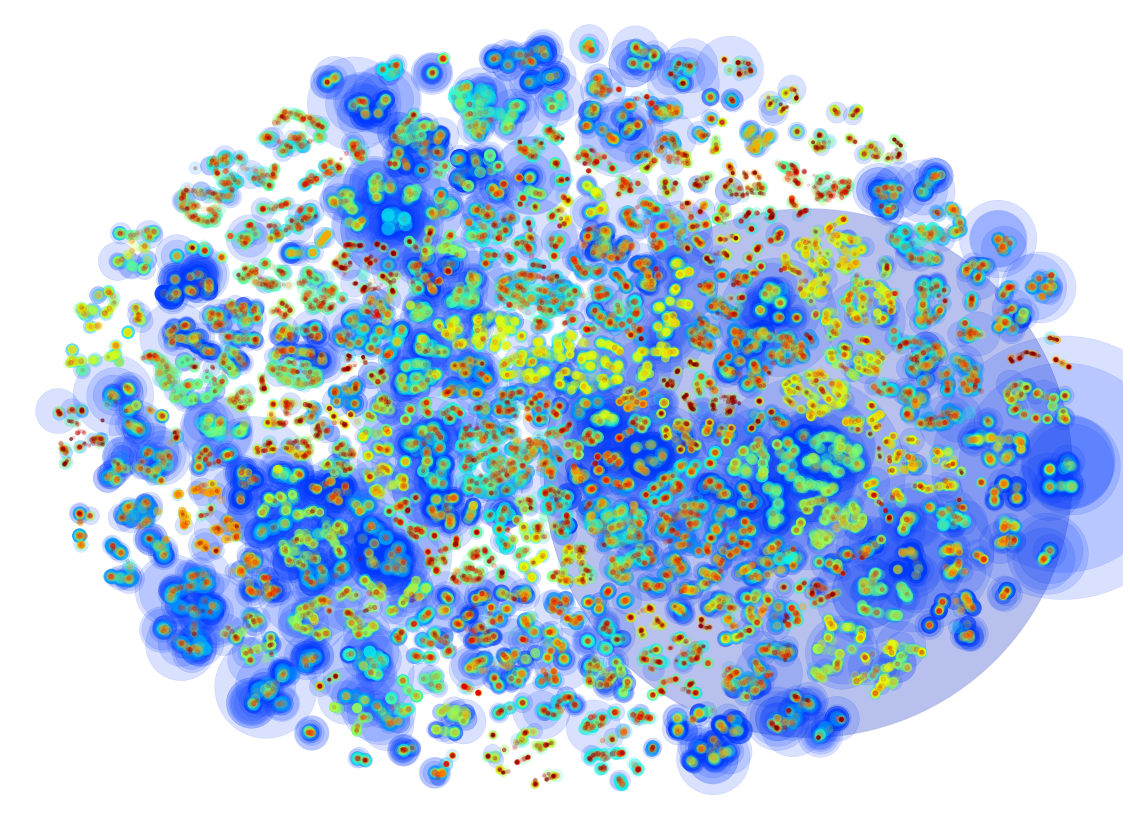

In [0]:
# TSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
%time X_sale_reduced_tsne = tsne.fit_transform(X_Sale_sampled)

plot_digits(X_sale_reduced_tsne, y_Sale_sampled, 10, figsize=(20,15))

Wall time: 128 ms


<module 'matplotlib.pyplot' from 'C:\\Programs\\Anaconda3\\envs\\tensorflow-env\\lib\\site-packages\\matplotlib\\pyplot.py'>

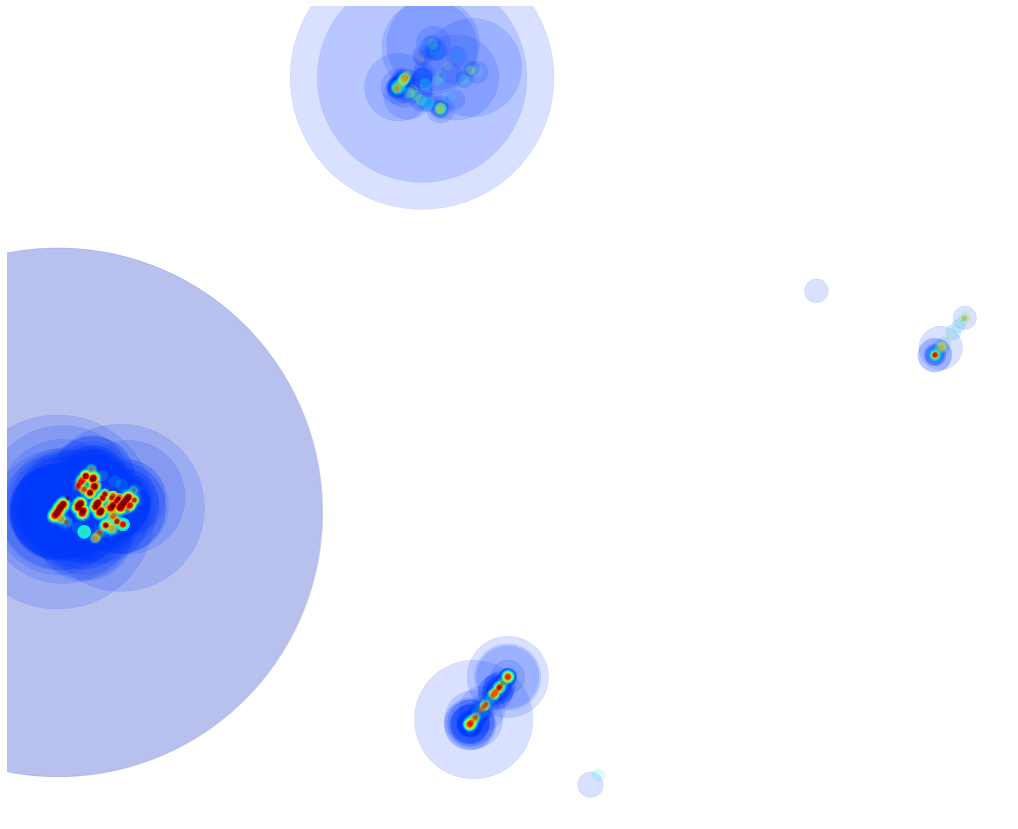

In [0]:
# PCA
from sklearn.decomposition import PCA

pca_2d = PCA(n_components=2, random_state=42)
%time X_sale_sampled_pca_2d = pca_2d.fit_transform(X_Sale_sampled)

plot_digits(X_sale_sampled_pca_2d, y_Sale_sampled, 10, figsize=(18,15))

In [0]:
* from PCA it looks there is some kind of data clustering there

In [0]:
# Remove LLE considering too long running
# from sklearn.manifold import LocallyLinearEmbedding

# m = 10000
# idx_sale = np.random.permutation(X_Sale_train.shape[0])[:m]

# X_Sale_sampled = X_Sale_train[idx_sale]
# y_Sale_sampled = y_Sale_train[idx_sale]
# lle_2d = LocallyLinearEmbedding(n_components=2, random_state=42, eigen_solver ="dense" )
# %time X_sale_sampled_lle_2d = lle_2d.fit_transform(X_Sale_sampled)
# plot_digits(X_sale_sampled_lle_2d, y_Sale_sampled, 10)

In [0]:
# %matplotlib inline
# import matplotlib.pyplot as plt
IowaSales_Main.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [0]:
pd.plotting.boxplot(IowaSales_Copy_Filled.iloc[:, 1:-1]);

* To use heap map to see  the correlation between features

In [0]:
plt.figure(figsize=(20,15))
sns.heatmap(IowaSales_Copy_Filled.iloc[:, 1:].corr(), center=0);

In [0]:
# Save data for Model part
IowaSales_Copy_Filled.to_csv(".\IowaSales_Copy_Filled_BeforeDrop.csv", index=False)